# Plotting MNIST

In [26]:
import os, sys

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import seaborn as sns

#Own files
from VAE.MNIST import VAE_MNIST
from torchgeometry.deep_geometry import rm_generative_models

## Loading MNIST

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset = dset.MNIST(root='../../Data/MNIST', train=True, download=True, transform=transform)

dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), int(0.8*len(dataset)), replace=False))

trainloader = DataLoader(dataset = dataset_subset, batch_size= 64,
                             shuffle = True, pin_memory = True, num_workers = 0)
device = 'cpu'

## Loading Model

In [7]:
lr = 0.0002
model = VAE_MNIST().to('cpu') #Model used
optimizer = optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load('models/mnist/vae_mnist_3.pt', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
elbo = checkpoint['ELBO']
rec_loss = checkpoint['rec_loss']
kld_loss = checkpoint['KLD']

model.eval()

M = rm_generative_models(model_encoder = model.h,
                        model_decoder = model.g)

## Plotting Learned Model

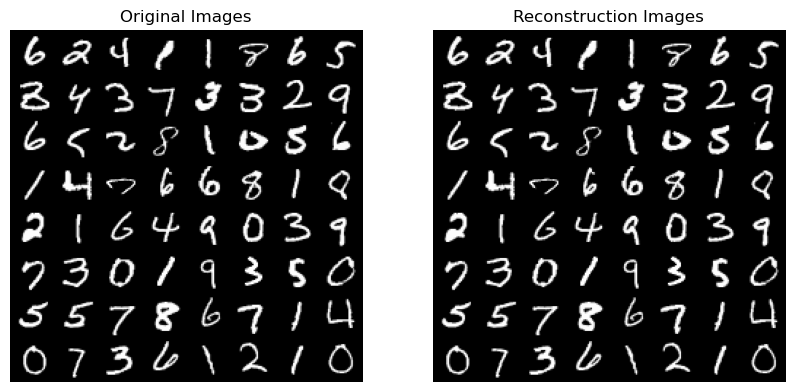

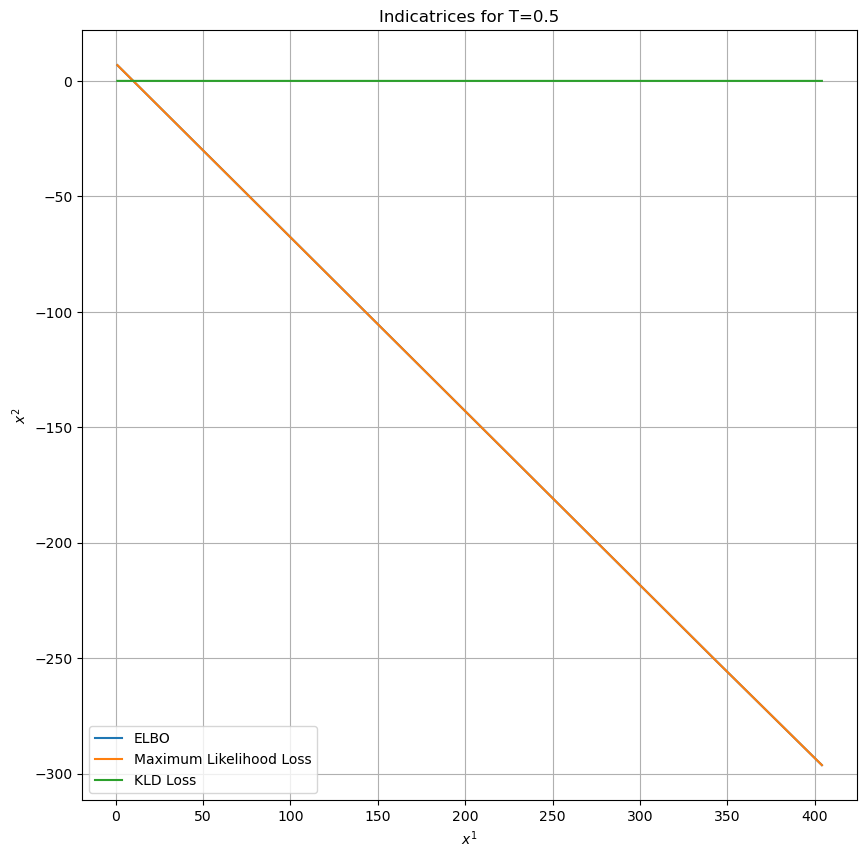

In [8]:
# Plot some training images
real_batch = next(iter(trainloader))
recon_batch = model(real_batch[0]) #x=z, x_hat, mu, var, kld.mean(), rec_loss.mean(), elbo
x_hat = recon_batch[1].detach().view(64,1,28,28)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

# Plot some training images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstruction Images")
plt.imshow(np.transpose(vutils.make_grid(x_hat.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,epoch+1,1), elbo, label='ELBO')
ax.plot(np.arange(1,epoch+1,1), rec_loss, label='Maximum Likelihood Loss')
ax.plot(np.arange(1,epoch+1,1), kld_loss, label='KLD Loss')
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices for T=0.5")
ax.grid()


## Latent Representation

In [9]:
trainloader = DataLoader(dataset = dataset, batch_size= len(dataset),
                             shuffle = True, pin_memory = True, num_workers = 0)


mu = []
labels = []
for x in trainloader:
    labels.append(x[1])
    mu.append(model.h(x[0]).detach().numpy())
    
mu = np.stack(mu).squeeze()
labels = np.stack(labels).squeeze()

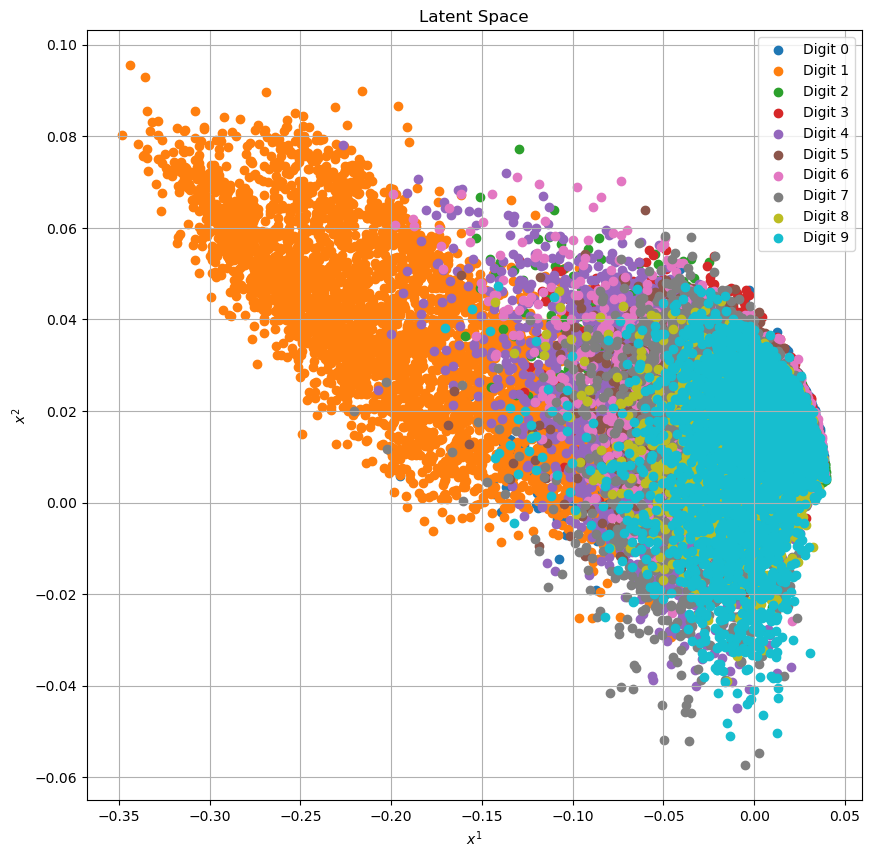

In [10]:
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in np.unique(labels):
    ax.scatter(mu[labels==i,0], mu[labels==i,1], label=' '.join(('Digit', str(i))))
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()

## Computing Geodesics

In [46]:
size = 28
   
#Get 3 images to compute geodesics for
subset_indices = [0, 1, 2, 3, 4, 5] # select your indices here as a list
dataset_subset = torch.utils.data.Subset(dataset, subset_indices)
   
img_height = size+2
img_n = len(subset_indices)

gamma_lst = []
gammaz_lst = []
arc_lst = []
tick_lst = []
T_lst = []

G_plot = torch.empty(1)
for i in range(int(img_n/2)):
    x = (dataset_subset[2*i][0]).view(1, 1, size, size).to(device)
    y = (dataset_subset[2*i+1][0]).view(1, 1, size, size).to(device)

    hx = model.h(x).to('cpu')
    hy = model.h(y).to('cpu')

    gamma_linear = M.linear_inter(hx, hy, 10)

    loss, gammaz_geodesic = M.compute_geodesic(gamma_linear,epochs=50000)
    gamma_g_geodesic = model.g(gammaz_geodesic)
    gamma_g_linear = model.g(gamma_linear)

    gammaz_geodesic = gammaz_geodesic.detach()
    gamma_g_linear = gamma_g_linear.detach()

    L_linear = M.arc_length(gamma_g_linear)
    L_geodesic = M.arc_length(gamma_g_geodesic)

    G_plot = torch.cat((gamma_g_linear.detach(), gamma_g_geodesic.detach()), dim = 0)

    arc_length = ['{0:.4f}'.format(L_linear), '{0:.4f}'.format(L_geodesic)]
    tick_list = [img_height/2, img_height/2+img_height]

    gammaz_lst.append(gammaz_geodesic)
    gamma_lst.append(G_plot.to('cpu'))
    arc_lst.append(arc_length)
    tick_lst.append(tick_list)
    T_lst.append(10)

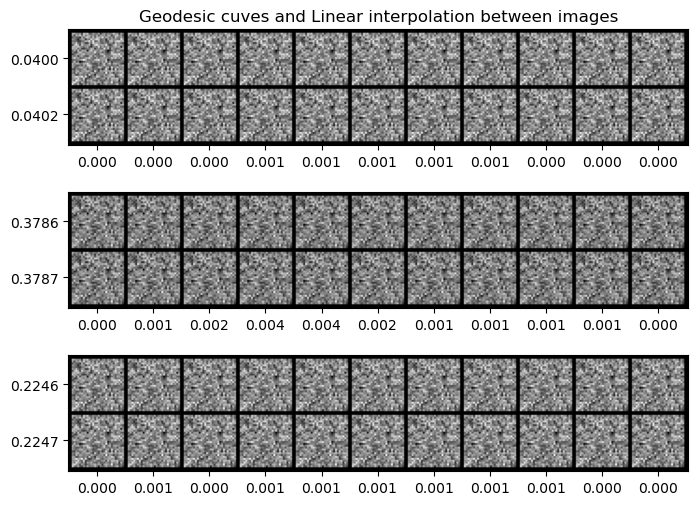

In [47]:
img_size = 28
fig, ax = plt.subplots(3,1, figsize=(8,6))
ax[0].set_title("Geodesic cuves and Linear interpolation between images")
img_height = img_size+2
for i in range(len(gamma_lst)):
   
    tick_list_x = []
    euc_length_x = []
      
    G_plot = gamma_lst[i].view(-1,1,28,28)
    arc_length = arc_lst[i]
    tick_list = tick_lst[i]
    T = T_lst[i]
   
    for j in range(T+1):
        tick_list_x.append(img_height/2+j*img_height)
        euc_length_x.append('{0:.3f}'.format(torch.norm((G_plot[j]-G_plot[j+T+1]).view(-1)).item()))

    ax[i].imshow(vutils.make_grid(G_plot, padding=2, normalize=True, nrow=T+1).permute(1, 2, 0))
    #ax[i].axes.get_xaxis().set_visible(False)
    ax[i].set_yticks(tick_list)
    ax[i].set_yticklabels(arc_length)
    ax[i].set_xticks(tick_list_x)
    ax[i].set_xticklabels(euc_length_x)

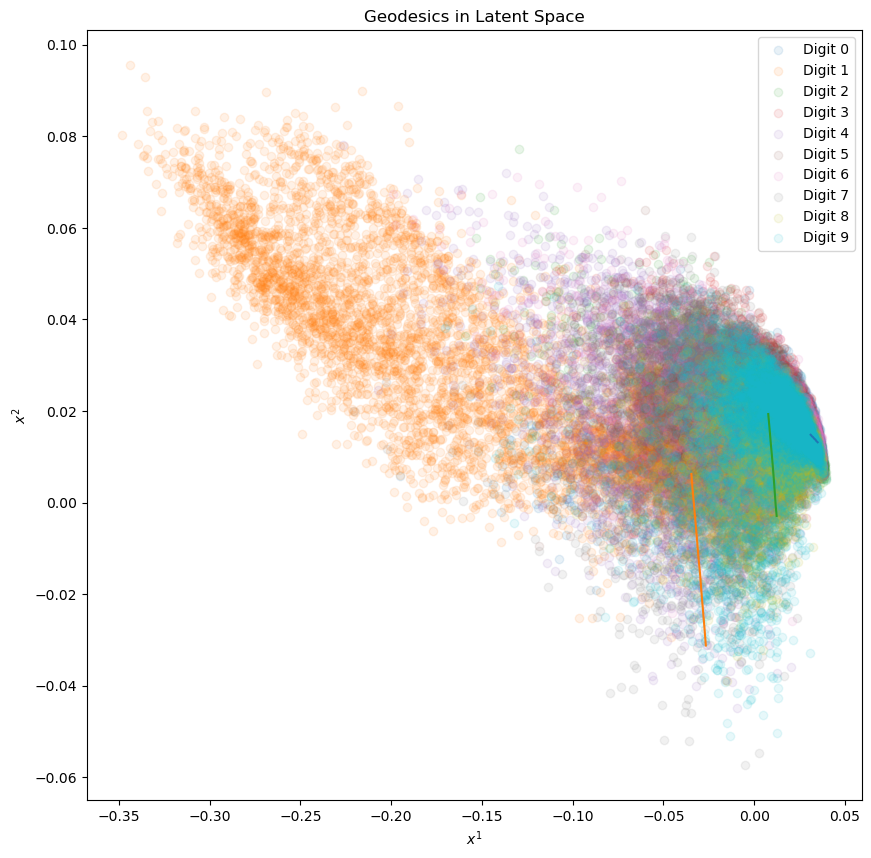

In [48]:
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in np.unique(labels):
    ax.scatter(mu[labels==i,0], mu[labels==i,1], label=' '.join(('Digit', str(i))), alpha=0.1)
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()
for i in range(len(gammaz_lst)):
    ax.plot(gammaz_lst[i][:,0], gammaz_lst[i][:,1])
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Geodesics in Latent Space")
ax.grid()

## RELAX 

In [52]:
def MaskGenerator(num_batches, mask_bs, inp_shape=28, num_cells=7, p=0.5, nsd=2, dev='cpu'):
    for batch_i in range(num_batches):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device='cpu')
        shift_y = torch.randint(0, num_cells, (mask_bs,), device='cpu')

        masks = torch.empty((mask_bs, 1, inp_shape, inp_shape), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i, :,
                               shift_x[i]:shift_x[i] + inp_shape,
                               shift_y[i]:shift_y[i] + inp_shape]

        yield masks

In [92]:
#@title Implement RELAX

def OnlineRELAX(X, h, Mbar, f_fun, s_fun = nn.CosineSimilarity(dim=1, eps=1e-6),
               R = None, U = None):
    
    with torch.no_grad():
        if R is None:
            R = torch.zeros((1, X.shape[1], X.shape[2]), device='cpu')

        if U is None:
            U = torch.zeros((1, X.shape[1], X.shape[2]), device='cpu')

        W = torch.zeros_like(R, device='cpu')+1e-8
        for m in Mbar:
            W += m
            hbar = f_fun(X*m)
            s = s_fun(h, hbar)
            R_prev = R
            R += m*(s-R)/W
            U += (s-R)*(s-R_prev )*m

        return R, U/(W-1)


Batch 1 of masked images.


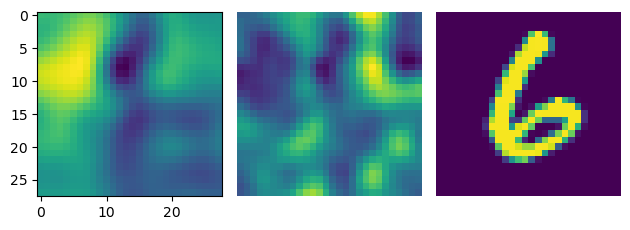

In [93]:
f_fun = model.h
num_masks = 1000
num_batches = 1
j = 0
for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
    R, U = OnlineRELAX(real_batch[0][0], model.h(real_batch[0][0]), mask, f_fun)#.squeeze()
    print(f"Batch {batch_i+1} of masked images.")
    plt.subplot(1,num_batches+2,j+1)
    plt.imshow(R.squeeze())
    plt.subplot(1,num_batches+2,j+2)
    plt.imshow(U.squeeze())
    plt.axis('off')
    j += 1
plt.subplot(1,num_batches+2,j+2)
plt.imshow(real_batch[0][0].squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

Batch 1 of masked images.


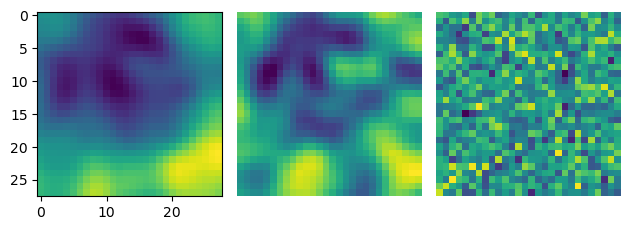

In [67]:
f_fun = model.h
num_masks = 1000
num_batches = 1
j = 0
for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
    R, U = OnlineRELAX(gamma_lst[0][5].view(1,28,28), gammaz_lst[0][5].view(1,2), mask, f_fun)#.squeeze()
    print(f"Batch {batch_i+1} of masked images.")
    plt.subplot(1,num_batches+2,j+1)
    plt.imshow(R.squeeze())
    plt.subplot(1,num_batches+2,j+2)
    plt.imshow(U.squeeze())
    plt.axis('off')
    j += 1
plt.subplot(1,num_batches+2,j+2)
plt.imshow(gamma_lst[0][5].view(1,28,28).squeeze())
plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
#@title Implement RELAX

def RELAX(X, h, Mbar, f_fun, s_fun = nn.CosineSimilarity(dim=1, eps=1e-6)):
    
    with torch.no_grad():
    #    R = torch.zeros((1, X.shape[2], X.shape[3]), device='cuda')
    #    for m in Mbar:
    #        hbar = f_fun(X*m)
    #        print(s_fun(h, hbar))
    #        R += s_fun(h, hbar)*m

    #    R /= len(Mbar)
    
    #return R
    
        hbar = f_fun(X*Mbar)
        R = s_fun(h, hbar)
    
    return R.mean(axis=0)


In [79]:
f_fun = model.h
num_masks = 1000
num_batches = 1
gamma_relax = []
gamma_dummy = []
for j in range(len(gamma_lst)):
    for k in range(int(len(gamma_lst[j])/2)):
        for batch_i, mask in enumerate(MaskGenerator(num_batches=num_batches, mask_bs=num_masks)):
            gamma_dummy.append(RELAX(gamma_lst[j][k].view(1,28,28), gammaz_lst[j][k].view(1,2), mask, f_fun))#.squeeze()
                               
    gamma_relax.append(torch.stack(gamma_dummy))
    gamma_dummy = []

TypeError: colorbar() missing 1 required positional argument: 'mappable'

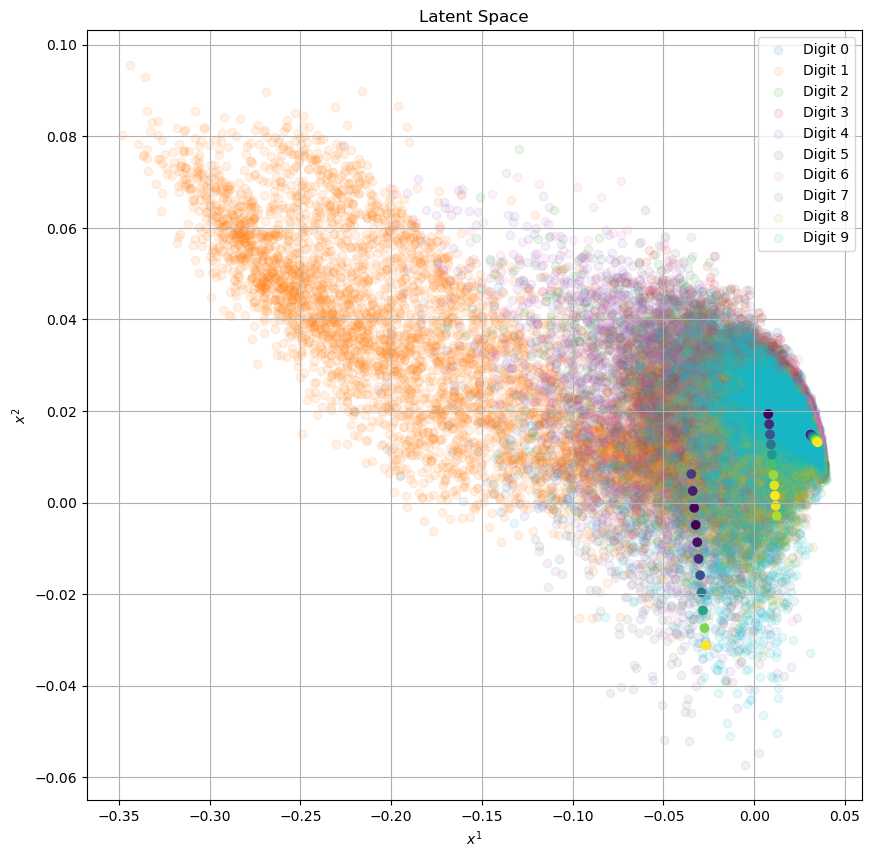

In [87]:
#Plotting loss function
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in np.unique(labels):
    ax.scatter(mu[labels==i,0], mu[labels==i,1], label=' '.join(('Digit', str(i))), alpha=0.1)
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Latent Space")
ax.grid()
for i in range(len(gammaz_lst)):
    ax.scatter(gammaz_lst[i][:,0], gammaz_lst[i][:,1], c=gamma_relax[i].detach().numpy())
fig.colorbar()
ax.legend()
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Geodesics in Latent Space")
ax.grid()

In [86]:
gamma_relax[1]

tensor([-0.7378, -0.7889, -0.8414, -0.8919, -0.9342, -0.9667, -0.9891, -0.9993,
        -0.9956, -0.9798, -0.9541])